In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import subprocess

In [2]:
def get_target(col):
    return col.split('.')[1].split(':')[0]

def load_target(path, target):
    try:
        return pickle.load(open('{}/{}.pkl'.format(DSC_PATH, path), 'rb'))[target]
    except Exception:
        return []

def load_query_targets(spec):
    """
    load query targets from DSC database
    """
    output_columns = spec.columns[['output' in c for c in spec.columns]]
    spec = deepcopy(spec)
    target2oc = {}
    for oc in output_columns:
        target = get_target(oc)
        if target in target2oc:
            target2oc[target].append(oc)
        else:
            target2oc[target] = [oc]

    for target in target2oc:
        fp = pd.concat([spec.loc[:, target2oc[target][i]].dropna() for i in range(len(target2oc[target]))])
        spec.loc[:, '{}_path'.format(target)] = fp

    targets = list(target2oc.keys())

    for target in targets:
        spec.loc[:, target] = spec.loc[:, '{}_path'.format(target)].apply(
            lambda x: load_target(x, target))
        spec = spec.drop(labels='{}_path'.format(target), axis=1)
    return spec

DSC_PATH = '../output/cafeh-simulations'

In [34]:
DSC_PATH = '../output/cafeh-simulations'

targets = [
    'fit_cafeh.credible_sets', 'fit_cafeh.purity', 'fit_cafeh.active',
    'fit_susie.credible_sets', 'fit_susie.purity',
    'simulations.true_effects',
    'simulations.pve', 'simulations.n_study', 'simulations.n_causal_per_study'
]

query_file = 'cset_query.xlsx'

cmd_args = [
    'dsc-query', DSC_PATH,
    '-t', ' '.join(targets),
    '-o', query_file
]

subprocess.run('rm {}'.format(query_file), shell=True)
subprocess.run(' '.join(cmd_args), shell=True)

CompletedProcess(args='dsc-query ../output/cafeh-simulations -t fit_cafeh.credible_sets fit_cafeh.purity fit_cafeh.active fit_susie.credible_sets fit_susie.purity simulations.true_effects simulations.pve simulations.n_study simulations.n_causal_per_study -o cset_query.xlsx', returncode=0)

In [35]:
xls = pd.ExcelFile(query_file)
info = [xls.parse(x) for x in xls.sheet_names]
spec = pd.read_excel(xls, 'Sheet1')
query = load_query_targets(spec)

# put model names into one column for easier filtering

model_columns = ['fit_cafeh', 'fit_susie']
query.loc[:, 'model'] = pd.concat(
    [query.loc[:, mc].dropna().apply(lambda x: '_'.join(x.split('_')[1:])) for mc in model_columns])

In [223]:
def _score_cset(causal_snps, credible_sets, purity):
    """
    causal_snps: list of causal snps
    credible_sets: {component: credible_set} dictionary
    purity: {component: purity} dictionary
    """
    # how many of these components are pure?
    pure = np.array([purity[k] > 0.5 for k in purity])

    # how many component contain a causal snp
    cs_contains_causal = np.array([np.any(np.isin(credible_sets[k], causal_snps))
                                   for k in credible_sets])
    try:
        all_credible_snps = np.unique(np.concatenate(
            [credible_sets[k] for k in credible_sets if (purity[k] > 0.5)]))
    except ValueError:
        all_credible_snps = np.array([])

    # how many causal snps are captured in a pure component
    causal_in_credible_set = np.isin(causal_snps, all_credible_snps)

    # how many causal snps are the first snp in a component
    top_credible_snps = np.unique([credible_sets[k][0] for k in credible_sets if (purity[k] > 0.5)])
    top_causal = np.isin(causal_snps, top_credible_snps)
        
    return {
        'n_components': pure.sum(),
        'n_components_with_causal': np.logical_and(cs_contains_causal, pure).sum(),
        'n_causal_in_cs': causal_in_credible_set.sum(),
        'n_top_causal': top_causal.sum(),
        'n_causal': causal_snps.size,
        'n_credible_snps': all_credible_snps.size
    }

def _score_study_cset(credible_sets, purity, true_effects, **kwargs):
    """
    compute finemapping scores at study level
    credible_sets: list of length #of studies of credible set dictionaries
    purity: list of length # of studies of credible set dictionaries
    """
    results = []
    for t in range(true_effects.shape[0]):
        # get the causal snps
        causal_snps = np.where(true_effects[t] != 0)[0]
        results.append(_score_cset(causal_snps, credible_sets[t], purity[t]))
    return results

In [248]:
def _score_study_cset_cafeh(credible_sets, purity, true_effects, active, **kwargs):
    """
    score cset for each study seperately
    """
    cs = []
    p = []
    for t, a in enumerate(active):
        active_in_study = np.arange(a.size)[a > 0.5]
        p.append({k: purity[k] for k in active_in_study if (k in purity)})
        cs.append({k: credible_sets[k] for k in active_in_study if (k in purity)})
    return _score_study_cset(cs, p, true_effects)

def _score_study_cset_susie(credible_sets, purity, true_effects, **kwargs):
    return _score_study_cset(credible_sets, purity, true_effects)


def score_study_cset(id_vars=None, **kwargs):
    if 'susie' in kwargs['model']:
        results = _score_study_cset_susie(**kwargs)
    else:
        results = _score_study_cset_cafeh(**kwargs)
    if id_vars is not None:
        id_vars = {id_var: kwargs.get(id_var, None) for id_var in id_vars}
        [r.update(id_vars) for r in results]
    return results

In [249]:
def _score_total_cset_susie(credible_sets, purity, true_effects, **kwargs):
    causal_snps = np.arange(true_effects.shape[1])[np.any(true_effects != 0, 0)]
    cs = {}
    p = {}
    
    counter = 0
    for t in range(len(credible_sets)):
        for k in credible_sets[t]:
            cs[counter] = credible_sets[t][k]
            p[counter] = purity[t][k]
            counter += 1
    return _score_cset(causal_snps, cs, p)

def _score_total_cset_cafeh(credible_sets, purity, true_effects, **kwargs):
    causal_snps = np.arange(true_effects.shape[1])[np.any(true_effects != 0, 0)]
    return _score_cset(causal_snps, credible_sets, purity)

def score_total_cset(id_vars=None, **kwargs):
    if 'susie' in kwargs['model']:
        results = _score_total_cset_susie(**kwargs)
    else:
        results = _score_total_cset_cafeh(**kwargs)

    if id_vars is not None:
        id_vars = {id_var: kwargs.get(id_var, None) for id_var in id_vars}
        results.update(id_vars)
    return results        

In [251]:
id_vars = ['model', 'simulations', 'simulations.pve', 'simulations.n_study', 'simulations.n_causal_per_study']

In [316]:
total_cset = pd.DataFrame([score_total_cset(id_vars=id_vars, **row.to_dict()) for _, row in query.iterrows()])
total_cset

,n_components,n_components_with_causal,n_causal_in_cs,n_top_causal,n_causal,n_credible_snps,model,simulations,simulations.pve,simulations.n_study,simulations.n_causal_per_study
0,2,2,2,2,2,3,susie_genotype,tissue_specific_sim,0.05,2,1
1,5,5,2,2,2,3,susie_genotype,tissue_specific_sim,0.05,5,1
2,10,10,3,3,3,3,susie_genotype,tissue_specific_sim,0.05,10,1
3,4,4,3,3,3,3,susie_genotype,tissue_specific_sim,0.05,2,2
4,7,7,5,4,7,12,susie_genotype,tissue_specific_sim,0.05,5,2
...,...,...,...,...,...,...,...,...,...,...,...
604,2,2,2,2,2,2,cafeh_summary_simple,global_effect_sim,0.10,5,2
605,2,1,1,1,2,2,cafeh_summary_simple,global_effect_sim,0.10,10,2
606,3,3,3,3,3,3,cafeh_summary_simple,global_effect_sim,0.10,2,3
607,3,2,2,2,3,7,cafeh_summary_simple,global_effect_sim,0.10,5,3


In [317]:
from itertools import chain
study_cset = pd.DataFrame(list(chain(*[score_study_cset(id_vars=id_vars, **row.to_dict()) for _, row in query.iterrows()])))
study_cset

,n_components,n_components_with_causal,n_causal_in_cs,n_top_causal,n_causal,n_credible_snps,model,simulations,simulations.pve,simulations.n_study,simulations.n_causal_per_study
0,1.0,1,1,1,1,2,susie_genotype,tissue_specific_sim,0.05,2,1
1,1.0,1,1,1,1,1,susie_genotype,tissue_specific_sim,0.05,2,1
2,1.0,1,1,0,1,2,susie_genotype,tissue_specific_sim,0.05,5,1
3,1.0,1,1,1,1,2,susie_genotype,tissue_specific_sim,0.05,5,1
4,1.0,1,1,1,1,1,susie_genotype,tissue_specific_sim,0.05,5,1
...,...,...,...,...,...,...,...,...,...,...,...
3446,1.0,1,1,1,3,1,cafeh_summary_simple,global_effect_sim,0.10,10,3
3447,3.0,3,3,1,3,5,cafeh_summary_simple,global_effect_sim,0.10,10,3
3448,2.0,2,2,1,3,3,cafeh_summary_simple,global_effect_sim,0.10,10,3
3449,3.0,3,3,1,3,5,cafeh_summary_simple,global_effect_sim,0.10,10,3


In [309]:
resample = lambda x: x.loc[np.random.choice(x.index.values, x.shape[0])]

compute_coverage = lambda x: x.n_components_with_causal.sum() / x.n_components.sum()
compute_power = lambda x: x.n_causal_in_cs.sum() / x.n_causal.sum()
compute_average_cs_size = lambda x: x.n_credible_sets.mean()

In [306]:
def make_bootstrap_df(function, df, id_vars, bootstrap_samples=100):
    coverage = pd.concat([df.groupby(id_vars).apply(
        lambda x: function(resample(x))) for _ in range(bootstrap_samples)], axis=1)
    return coverage.reset_index().melt(id_vars=id_vars)

## Total cset analysis

Make plots for total-credible set analysis
that is, assess finemapping on each group of studies

### Coverage

/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


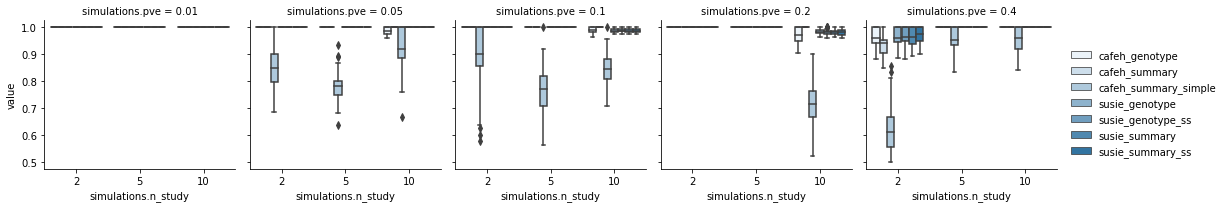

In [310]:
total_cset_coverage = make_bootstrap_df(compute_coverage, total_cset, ['model', 'simulations.n_study', 'simulations.pve'])

g = sns.FacetGrid(data=total_cset_coverage, col='simulations.pve')
g.map(sns.boxplot, 'simulations.n_study', 'value', 'model')
g.add_legend()

### Power

/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


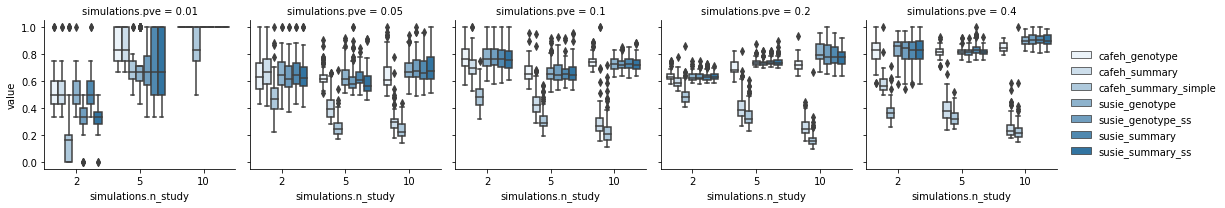

In [311]:
total_cset_averge_cs_size = make_bootstrap_df(compute_averge_cs_size, total_cset, ['model', 'simulations.n_study', 'simulations.pve'])

g = sns.FacetGrid(data=total_cset_averge_cs_size, col='simulations.pve')
g.map(sns.boxplot, 'simulations.n_study', 'value', 'model')
g.add_legend()

### Credible set size

/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


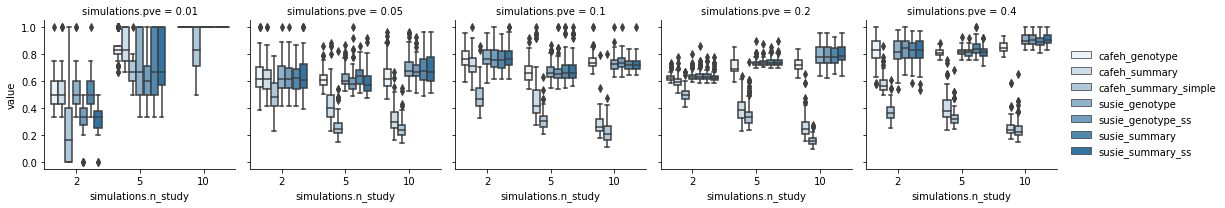

In [312]:
total_cset_power = make_bootstrap_df(compute_power, total_cset, ['model', 'simulations.n_study', 'simulations.pve'])

g = sns.FacetGrid(data=total_cset_power, col='simulations.pve')
g.map(sns.boxplot, 'simulations.n_study', 'value', 'model')
g.add_legend()

## study cset analysis

Make plots for study level-credible set analysis
home field for susie-- we construct study level credible sets for CAFEH
that is, assess finemapping on each group of studies

### Coverage

/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


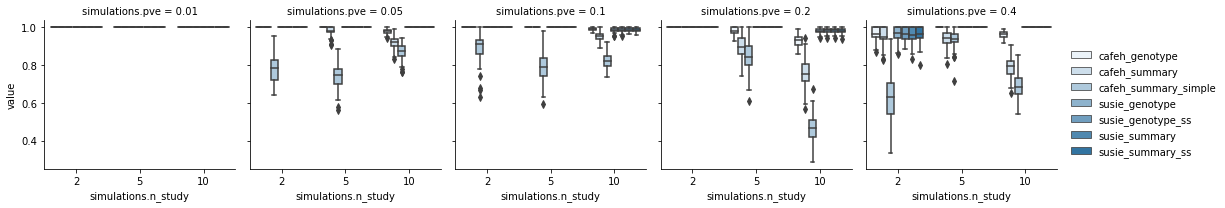

In [318]:
study_cset_coverage = make_bootstrap_df(compute_coverage, study_cset, ['model', 'simulations.n_study', 'simulations.pve'])

g = sns.FacetGrid(data=study_cset_coverage, col='simulations.pve')
g.map(sns.boxplot, 'simulations.n_study', 'value', 'model')
g.add_legend()

### Power

/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


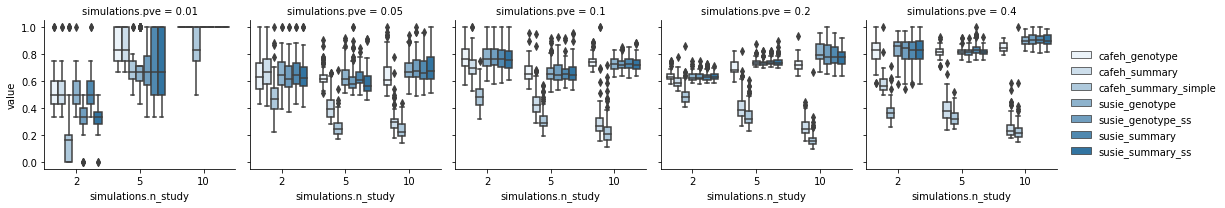

In [311]:
total_cset_averge_cs_size = make_bootstrap_df(compute_averge_cs_size, total_cset, ['model', 'simulations.n_study', 'simulations.pve'])

g = sns.FacetGrid(data=total_cset_averge_cs_size, col='simulations.pve')
g.map(sns.boxplot, 'simulations.n_study', 'value', 'model')
g.add_legend()

### Credible set size

/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


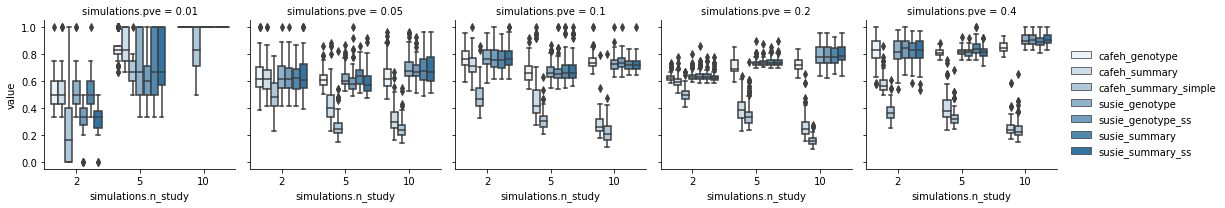

In [312]:
total_cset_power = make_bootstrap_df(compute_power, total_cset, ['model', 'simulations.n_study', 'simulations.pve'])

g = sns.FacetGrid(data=total_cset_power, col='simulations.pve')
g.map(sns.boxplot, 'simulations.n_study', 'value', 'model')
g.add_legend()

## Total cset analysis

Make plots for total-credible set analysis
that is, assess finemapping on each group of studies

### Coverage

/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


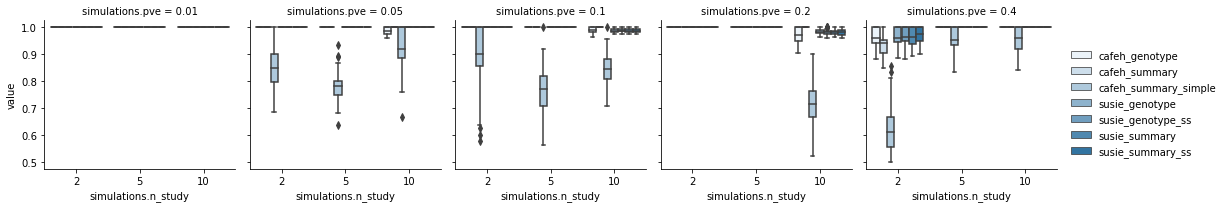

In [310]:
total_cset_coverage = make_bootstrap_df(compute_coverage, total_cset, ['model', 'simulations.n_study', 'simulations.pve'])

g = sns.FacetGrid(data=total_cset_coverage, col='simulations.pve')
g.map(sns.boxplot, 'simulations.n_study', 'value', 'model')
g.add_legend()

### Power

/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


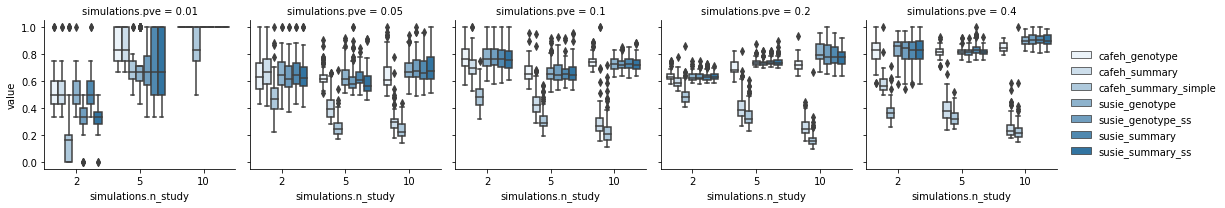

In [311]:
total_cset_averge_cs_size = make_bootstrap_df(compute_averge_cs_size, total_cset, ['model', 'simulations.n_study', 'simulations.pve'])

g = sns.FacetGrid(data=total_cset_averge_cs_size, col='simulations.pve')
g.map(sns.boxplot, 'simulations.n_study', 'value', 'model')
g.add_legend()

### Credible set size

/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


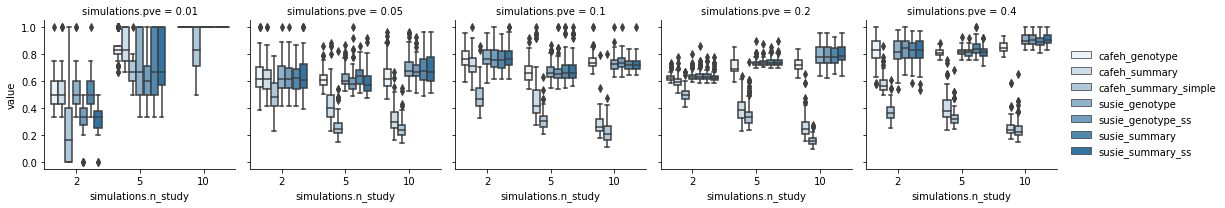

In [312]:
total_cset_power = make_bootstrap_df(compute_power, total_cset, ['model', 'simulations.n_study', 'simulations.pve'])

g = sns.FacetGrid(data=total_cset_power, col='simulations.pve')
g.map(sns.boxplot, 'simulations.n_study', 'value', 'model')
g.add_legend()

In [196]:
score_total_cset(id_vars=id_vars, **query.iloc[0].to_dict())

{'n_components': 2,
 'n_components_with_causal': 2,
 'n_causal_in_cs': 2,
 'n_top_causal': 2,
 'n_causal': 2,
 'n_credible_snps': 3,
 'model': None,
 'simulations.pve': 0.05,
 'simulations.n_study': 2,
 'simulations.n_causal_per_study': 1}

In [177]:
score_total_cset(**query.iloc[-1].to_dict())

{'n_components': 3,
 'n_components_with_causal': 3,
 'n_causal_in_cs': 3,
 'n_top_causal': 1,
 'n_causal': 3,
 'n_credible_snps': 5}

In [174]:
_score_study_cset_susie(**query.iloc[0].to_dict())

[{'n_components': 1,
  'n_components_with_causal': 1,
  'n_causal_in_cs': 1,
  'n_top_causal': 1,
  'n_causal': 1,
  'n_credible_snps': 2},
 {'n_components': 1,
  'n_components_with_causal': 1,
  'n_causal_in_cs': 1,
  'n_top_causal': 1,
  'n_causal': 1,
  'n_credible_snps': 1}]

In [166]:
_score_total_cset_susie(**query.iloc[0].to_dict())

{'n_components': 2,
 'n_components_with_causal': 2,
 'n_causal_in_cs': 2,
 'n_top_causal': 2,
 'n_causal': 2}

In [139]:
score_total_cset_susie(**query.iloc[0].to_dict())

{'n_components': 2,
 'n_components_with_causal': 2,
 'n_causal_in_cs': 2,
 'n_top_causal': 2,
 'n_causal': 2}

In [140]:
score_total_cset_cafeh(**query.iloc[-1].to_dict())

{'n_components': 3,
 'n_components_with_causal': 3,
 'n_causal_in_cs': 3,
 'n_top_causal': 1,
 'n_causal': 3}

In [141]:
score_total_cset_cafeh(**query.iloc[-1].to_dict())

{'n_components': 3,
 'n_components_with_causal': 3,
 'n_causal_in_cs': 3,
 'n_top_causal': 1,
 'n_causal': 3}

In [123]:
score_study_cset_cafeh(**query.iloc[-1].to_dict())

[{'n_components': 2,
  'n_components_with_causal': 2,
  'n_causal_in_cs': 2,
  'n_top_causal': 1,
  'n_causal': 3},
 {'n_components': 2,
  'n_components_with_causal': 2,
  'n_causal_in_cs': 2,
  'n_top_causal': 1,
  'n_causal': 3},
 {'n_components': 3,
  'n_components_with_causal': 3,
  'n_causal_in_cs': 3,
  'n_top_causal': 1,
  'n_causal': 3},
 {'n_components': 3,
  'n_components_with_causal': 3,
  'n_causal_in_cs': 3,
  'n_top_causal': 1,
  'n_causal': 3},
 {'n_components': 2,
  'n_components_with_causal': 2,
  'n_causal_in_cs': 2,
  'n_top_causal': 1,
  'n_causal': 3},
 {'n_components': 1,
  'n_components_with_causal': 1,
  'n_causal_in_cs': 1,
  'n_top_causal': 1,
  'n_causal': 3},
 {'n_components': 3,
  'n_components_with_causal': 3,
  'n_causal_in_cs': 3,
  'n_top_causal': 1,
  'n_causal': 3},
 {'n_components': 2,
  'n_components_with_causal': 2,
  'n_causal_in_cs': 2,
  'n_top_causal': 1,
  'n_causal': 3},
 {'n_components': 3,
  'n_components_with_causal': 3,
  'n_causal_in_cs'

In [31]:
def score_cset_cafeh(credible_sets, purity, true_effects):
    """
    score cset for each study seperately
    """

    # get the causal snps
    causal_snps = np.where(np.any(true_effects != 0, 0))[0]

    # how many of these components are pure?
    pure = np.array([purity[k] > 0.5 for k in range(len(purity))])

    # how many component contain a causal snp
    cs_contains_causal = np.array([np.any(np.isin(credible_sets[k], causal_snps))
                                   for k in range(len(credible_sets))])
    try:
        all_credible_snps = np.unique(np.concatenate(
            [credible_sets[k] for k in range(len(credible_sets)) if pure[k]]))
    except ValueError:
        all_credible_snps = np.array([])

    # how many causal snps are captured in a pure component
    causal_in_credible_set = np.isin(causal_snps, all_credible_snps)

    # how many causal snps are the first snp in a component
    top_credible_snps = np.unique([credible_sets[k][0] for k in range(len(credible_sets)) if pure[k]])
    top_causal = np.isin(causal_snps, top_credible_snps)

    return {
        'n_components': pure.sum(),
        'n_components_with_causal': (cs_contains_causal & pure).sum(),
        'n_causal_in_cs': causal_in_credible_set.sum(),
        'n_top_causal': top_causal.sum(),
        'n_causal': causal_snps.size
    }

In [ ]:
def score_cset_susie(credible_sets, purity, true_effects):
    """
    compute finemapping scores
    """

    # get the causal snps
    causal_snps = np.where(np.any(true_effects != 0, 0))[0]

    # how many of these components are pure?
    pure = np.array([purity[k] > 0.5 for k in range(len(purity))])

    # how many component contain a causal snp
    cs_contains_causal = np.array([np.any(np.isin(credible_sets[k], causal_snps))
                                   for k in range(len(credible_sets))])
    try:
        all_credible_snps = np.unique(np.concatenate(
            [credible_sets[k] for k in range(len(credible_sets)) if pure[k]]))
    except ValueError:
        all_credible_snps = np.array([])

    # how many causal snps are captured in a pure component
    causal_in_credible_set = np.isin(causal_snps, all_credible_snps)

    # how many causal snps are the first snp in a component
    top_credible_snps = np.unique([credible_sets[k][0] for k in range(len(credible_sets)) if pure[k]])
    top_causal = np.isin(causal_snps, top_credible_snps)

    return {
        'n_components': pure.sum(),
        'n_components_with_causal': (cs_contains_causal & pure).sum(),
        'n_causal_in_cs': causal_in_credible_set.sum(),
        'n_top_causal': top_causal.sum(),
        'n_causal': causal_snps.size
    }

In [19]:
xls = pd.ExcelFile(query_file)
info = [xls.parse(x) for x in xls.sheet_names]
spec = pd.read_excel(xls, 'Sheet1')
query = load_query_targets(spec)

# put model names into one column for easier filtering

model_columns = ['fit_cafeh', 'fit_susie']
query.loc[:, 'model'] = pd.concat(
    [query.loc[:, mc].dropna().apply(lambda x: '_'.join(x.split('_')[1:])) for mc in model_columns])

In [28]:
def true_effects2causal(true_effects):
    return np.arange(true_effects.shape[1])[np.any((true_effects != 0), 0)]

In [30]:
query.loc[:, 'causal_snps'] = query.true_effects.apply(true_effects2causal)

In [25]:
causal_snps = np.arange(1000)[np.any((query.iloc[0].true_effects != 0), 0)]

In [ ]:
!rm study_pip.xlsx
!dsc-query {DSC_PATH} -t score_finemapping_caviar.study_pip fit_cafeh.study_pip fit_susie.study_pip simulations.true_effects simulations.pve simulations.n_study simulations.n_causal_per_study -o study_pip.xlsx